In [1]:
# Manually cropping whole culture videos takes a long time, when there's a lot of them that need doing.
# This is helpful for any automated measurement task where we don't care about anything outside the culture area.
# Prior to spot detection in trackmate, particle image velocitometry, thresholding, etc. 

# This code takes a .tif containing a whole culture video, identifies a large circle
    # (using known dimensions to keep it reasonable)
    # and sets everything outside that circle to zero.
# The zeroed image is then saved as a .tif.
# Something went wrong with the formatting (?) here such that it takes much longer to open an autozeroed image
    # than one done manually in imageJ.
# However, it's good enough and I was in a crunch so I never bothered to deal with it.

# If you actually end up using this, 1. shoot me an email bc that's shocking to me & I'd love to hear about it,
    # and 2. make sure to check the output to make sure it all cropped correctly.
# It does a good enough job about 90% of the time. Faster to check the output than to actually open all those files.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

def croppem(folder):
    # get list of files to process
    tbd = os.listdir(folder)
    
    # create processed folder if it doesn't already exist
    processed_folder = os.path.join(folder, 'processed')
    os.makedirs(processed_folder, exist_ok=True)

    for current in tbd:
        if os.path.isfile(os.path.join(folder, current)):
            print('Now on:' + str(current))
            image = io.imread(os.path.join(folder, current)).astype('uint16')
            interest = image[3, :, :, 0].astype(np.uint8)

            # Resize the image to speed up processing
            scale_factor = 0.25
            resized_image = cv2.resize(interest, None, fx=scale_factor, fy=scale_factor)
        
            # Apply Gaussian blur to reduce noise
            blurred_image = cv2.GaussianBlur(resized_image, (9, 9), 2)

            # Apply adaptive thresholding
            adaptive_thresh = cv2.adaptiveThreshold(
                blurred_image, 
                255, 
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                cv2.THRESH_BINARY, 
                51, 
                2
            )
            print('looking for circles')
            # Perform Hough Circle Transform to detect circles
            circles = cv2.HoughCircles(
                adaptive_thresh, 
                cv2.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=1000,    # Adjusted for resized image
                param1=50, 
                param2=30, 
                minRadius=int(2080 * scale_factor), 
                maxRadius=int(2250 * scale_factor)
            )
            
            # Check if circles were detected
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                x, y, r = circles[0]

                # Create the boolean mask and set pixels outside the circle to zero
                mask = np.zeros_like(interest, dtype=np.uint8)
                mask= cv2.circle(mask, (int(x/scale_factor), int(y/scale_factor)), int(r/scale_factor), 1, thickness=-1)
                mask_stack = np.repeat(mask[np.newaxis, :, :], image.shape[0], axis=0)
                masked_image = image.copy()
                masked_image[mask_stack==0] = 0


                # Save the cropped image as a 16-bit TIFF file
                output_path = os.path.join(processed_folder, current[:-4] + '_cropped.tif')
                io.imsave(output_path, masked_image.astype(np.uint16), check_contrast=False)

                # Display the results
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))

                ax[0].imshow(interest, cmap='gray')
                ax[0].set_title('Original Image with Detected Circle')

                ax[1].imshow(masked_image[1,:, :, 0], cmap='gray')
                ax[1].set_title('Image w/ mask cut out')

                plt.show()

                print(f"Image saved to {output_path}")

            else:
                print("No circles detected. Try adjusting the parameters.")
        

Now on:mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_02_R3D.tif
looking for circles


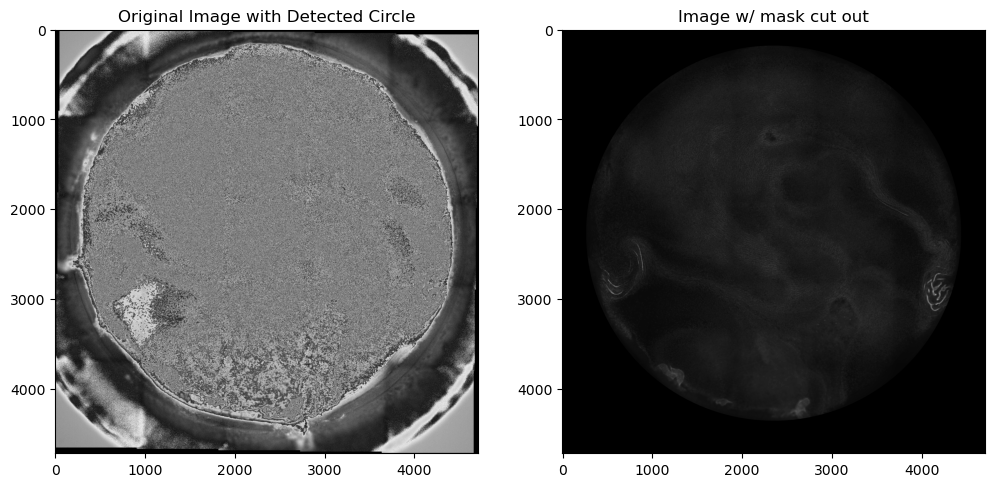

Image saved to D:/ciliako34_pre/processed\mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_02_R3D_cropped.tif
Now on:mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_06_R3D.tif
looking for circles


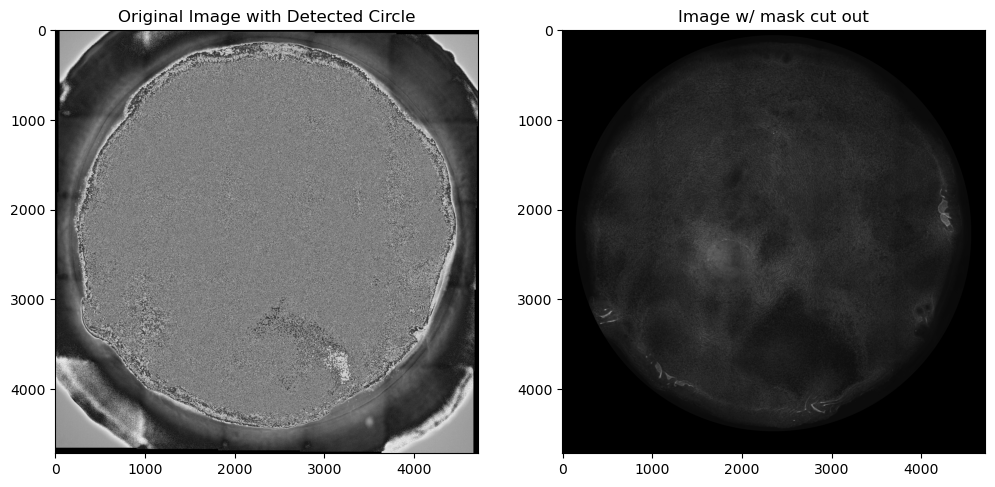

Image saved to D:/ciliako34_pre/processed\mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_06_R3D_cropped.tif
Now on:mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_19_R3D.tif
looking for circles


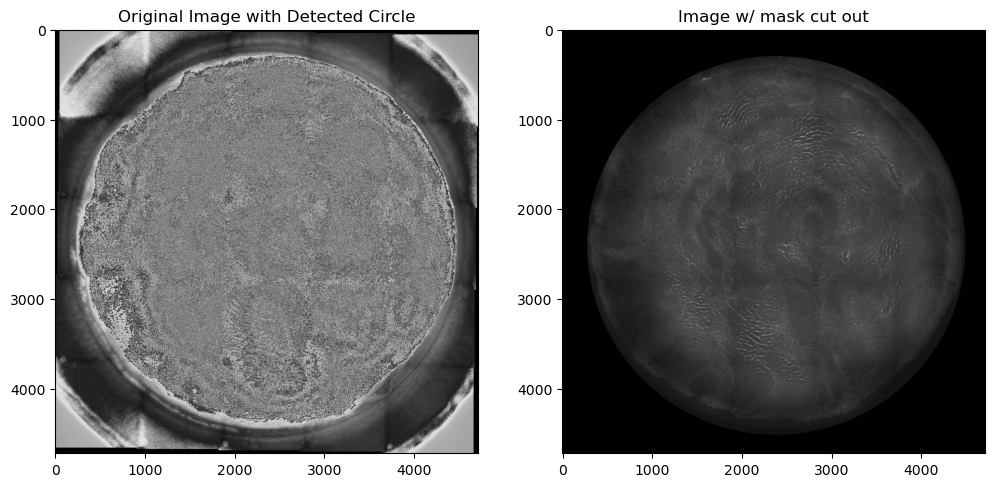

Image saved to D:/ciliako34_pre/processed\mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_19_R3D_cropped.tif
Now on:mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_20_R3D.tif
looking for circles


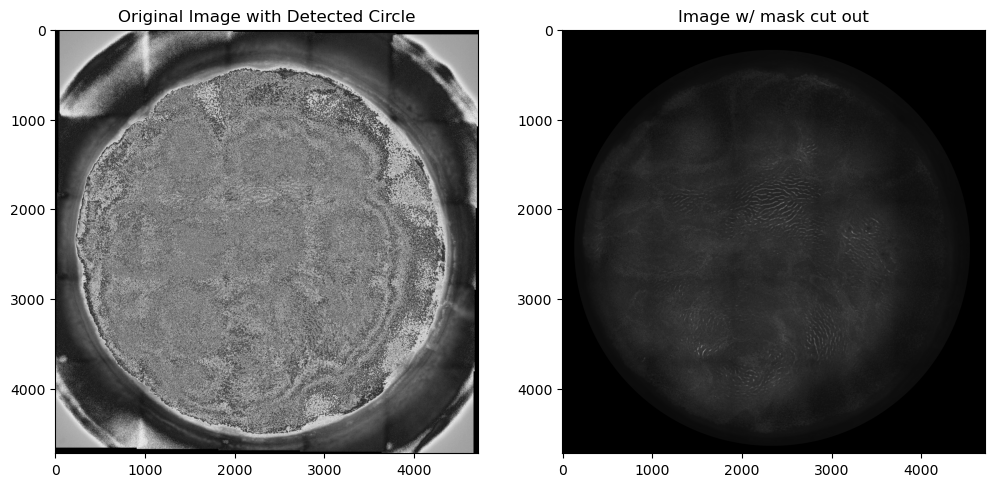

Image saved to D:/ciliako34_pre/processed\mb_240312_ciliako44_preinf2_cy5_spytub_tritc_nucview_pol_20_R3D_cropped.tif


In [3]:
# Usage example:

folder = 'D:/d7d8/'
croppem(folder)
